In [10]:
import sys
sys.path.append('../scripts/')

In [17]:
import itertools
import numpy as np

import torch
import torch.nn as nn
from matplotlib import pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold

from train_helpers import train, gen_loaders
from constants import test_metrics, mlp_features_columns
from utilities import load_data, open_log, clip_features_inplace, transform_data

In [13]:

if not torch.cuda.is_available():
    print('WARNING: using CPU.')
    log.write('\tWARNING: using CPU.\n')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data analysis

In [36]:
X, y = load_data()

plot the distribution of the dataset

In [37]:
plot_x = X
# plot_x = x_train
# plot_x = x_test

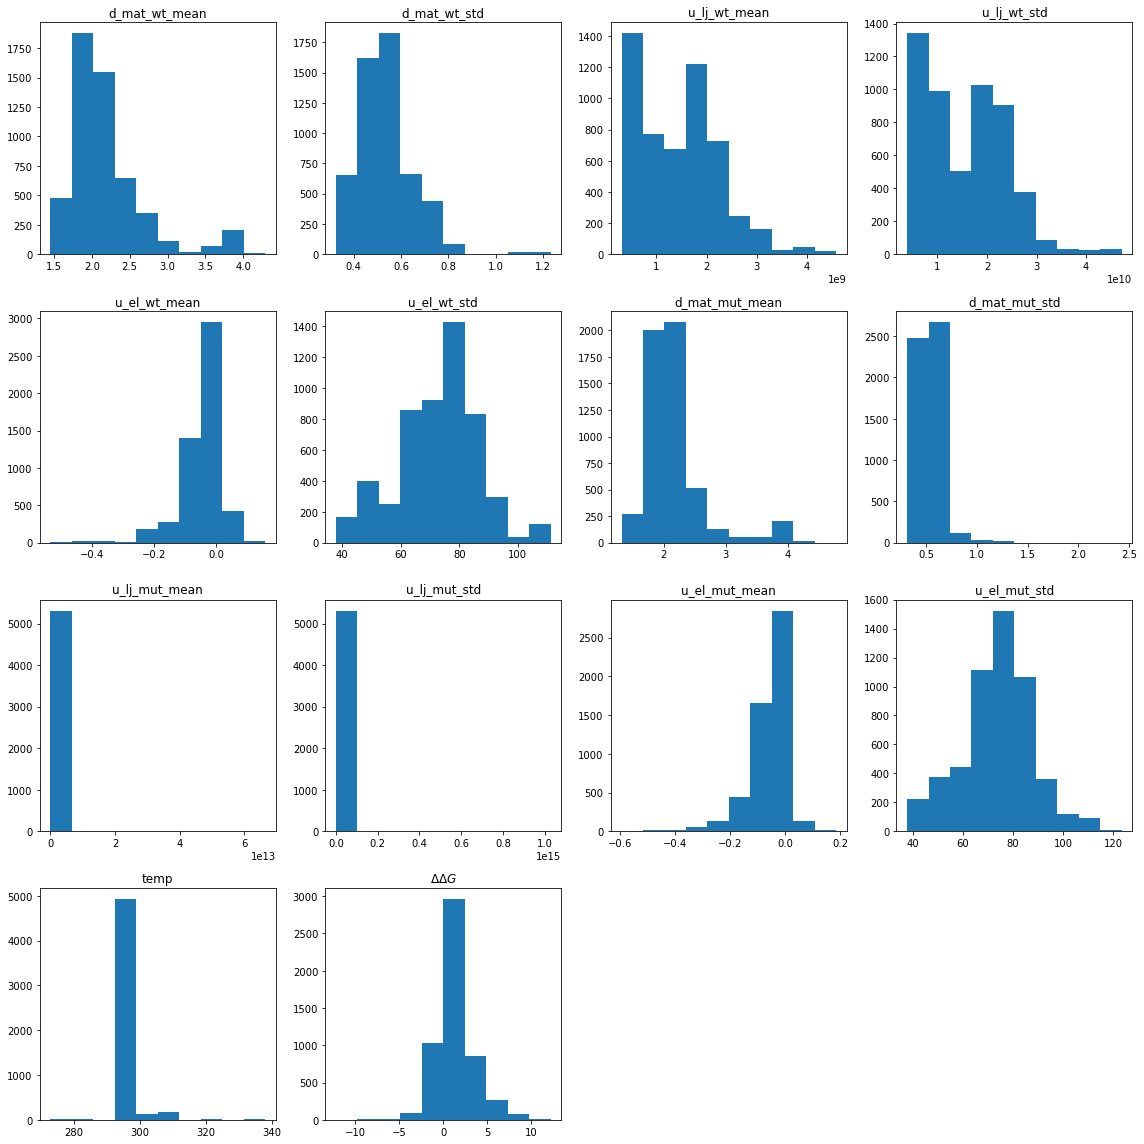

In [38]:
fig = plt.figure(figsize=(16,16))

N = len(mlp_features_columns)
Nsqrt = int(np.sqrt(N)+0.5)
for i in range(1, N-1):
    fig.add_subplot(Nsqrt, Nsqrt, i)
    plt.hist(plot_x[:, i-1])
    plt.title(mlp_features_columns[i])
fig.add_subplot(Nsqrt, Nsqrt, N-1)
plt.hist(y)
plt.title('$\Delta\Delta G$')

fig.tight_layout()
plt.savefig('mlp_features.png')
plt.show()

In [39]:
print(f'min-max temperature: {np.min(X[:, -1]), np.max(X[:, -1])}')

min-max temperature: (273.0, 338.0)


Lennard Jones mean energies and standard deviations have a few outliers that skew the distribution.

Here we show the 50 lowest and highest values of these features, showing that the values with different orders of magnitude are few,

In [40]:
# u_lj_mut_mean
sulj = np.sort(X[:, 8])
print(sulj[:50])
print('------------------------------------------------------------------------')
print(sulj[-50:])

[1.7632048e+07 7.1916128e+07 1.1811210e+08 1.2835631e+08 1.8011027e+08
 2.2859688e+08 2.4302322e+08 2.4408126e+08 2.5812794e+08 2.7120733e+08
 2.7596506e+08 2.7706611e+08 2.7980560e+08 2.8106387e+08 2.8964394e+08
 2.9378864e+08 2.9405846e+08 2.9749674e+08 2.9802797e+08 3.0201165e+08
 3.0394406e+08 3.0427811e+08 3.0731802e+08 3.1022426e+08 3.1174541e+08
 3.1191888e+08 3.1257814e+08 3.1273395e+08 3.1476800e+08 3.1567309e+08
 3.1822333e+08 3.1934714e+08 3.1941062e+08 3.2093366e+08 3.2205062e+08
 3.2245779e+08 3.2250109e+08 3.2595123e+08 3.2963533e+08 3.3275763e+08
 3.3341581e+08 3.3610202e+08 3.3634259e+08 3.3679661e+08 3.4005165e+08
 3.4063434e+08 3.4191907e+08 3.4210288e+08 3.4223795e+08 3.4283123e+08]
------------------------------------------------------------------------
[4.3439667e+09 4.3630259e+09 4.3868969e+09 4.3969623e+09 4.4157297e+09
 4.4225121e+09 4.4972390e+09 4.5376154e+09 4.5526083e+09 4.5580488e+09
 4.5679718e+09 4.5881037e+09 4.6267715e+09 4.6456837e+09 4.6472888e+09
 4.

In [41]:
# u_lj_mut_std
sulj = np.sort(X[:, 9])
print(sulj[:50])
print('------------------------------------------------------------------------')
print(sulj[-50:])

[1.6014123e+08 8.0908301e+08 1.3645549e+09 1.4535834e+09 1.9082806e+09
 2.2580173e+09 2.5190996e+09 2.8086838e+09 2.8440896e+09 2.9842179e+09
 3.0818414e+09 3.1387415e+09 3.2927841e+09 3.4363218e+09 3.5477371e+09
 3.7809357e+09 3.8748091e+09 3.8770778e+09 4.0147092e+09 4.0357760e+09
 4.0695926e+09 4.0772595e+09 4.0805681e+09 4.1109862e+09 4.1151588e+09
 4.1187226e+09 4.1267479e+09 4.1653832e+09 4.2052782e+09 4.2093204e+09
 4.2105574e+09 4.2222671e+09 4.2342182e+09 4.2647772e+09 4.2860792e+09
 4.2951434e+09 4.3256765e+09 4.3391933e+09 4.3436170e+09 4.3554171e+09
 4.3717612e+09 4.3798077e+09 4.3900365e+09 4.3935565e+09 4.3947203e+09
 4.4023096e+09 4.4174029e+09 4.4228081e+09 4.4245760e+09 4.4373903e+09]
------------------------------------------------------------------------
[4.51338813e+10 4.51371704e+10 4.52961935e+10 4.53762417e+10
 4.53974589e+10 4.54239150e+10 4.55829176e+10 4.59588895e+10
 4.59691827e+10 4.60539576e+10 4.62515610e+10 4.63993815e+10
 4.64147866e+10 4.64621363e+10 4.

clip these features,

In [42]:
X_clip = np.copy(X)

In [51]:
X_clip[:, 8] = np.clip(X[:, 8], 1e8, 5e9) # u_lj_mut_mean
X_clip[:, 9] = np.clip(X[:, 9], 1e8, 5e10) # u_lj_mut_std

In [52]:
x_train, x_test, y_train, y_test = train_test_split(
    X_clip, y, test_size=.2, random_state=42)

In [53]:
# standardize data
x_train, x_test = transform_data(x_train, x_test, degree=1, log=False, cross=False)

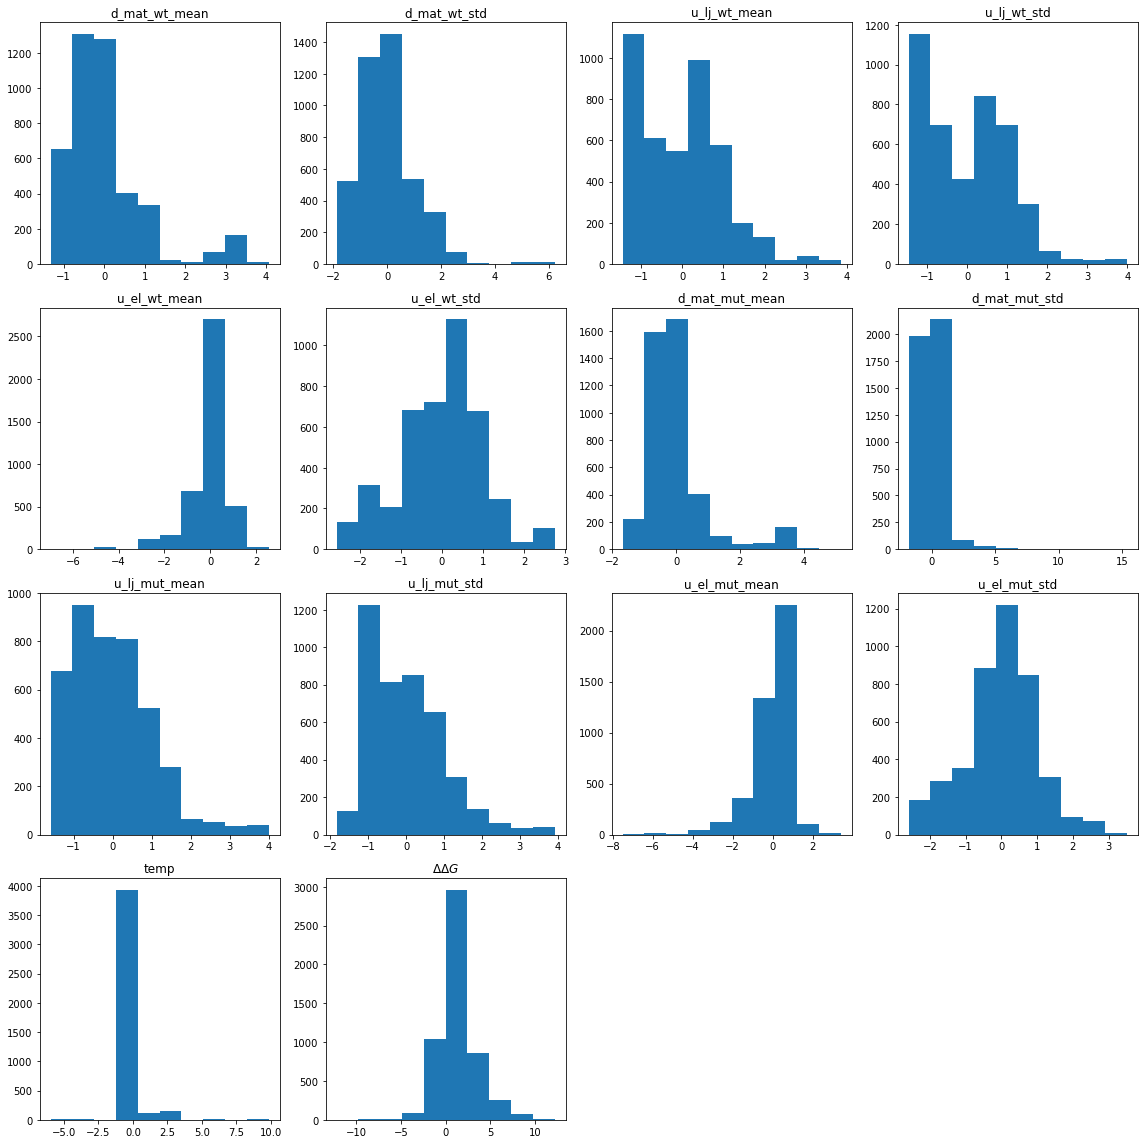

In [54]:
from matplotlib import pylab as plt
fig = plt.figure(figsize=(16,16))

N = len(mlp_features_columns)
Nsqrt = int(np.sqrt(N)+0.5)
for i in range(1, N-1):
    fig.add_subplot(Nsqrt, Nsqrt, i)
    plt.hist(x_train[:, i])
    plt.title(mlp_features_columns[i])
fig.add_subplot(Nsqrt, Nsqrt, N-1)
plt.hist(y)
plt.title('$\Delta\Delta G$')

fig.tight_layout()
plt.savefig('mlp_features.png')
plt.show()

In [55]:
# u_lj_mut_mean
sulj = np.sort(X[:, 8])
print(sulj[:50])
print('------------------------------------------------------------------------')
print(sulj[-50:])

[1.0000000e+08 1.0000000e+08 1.1811210e+08 1.2835631e+08 1.8011027e+08
 2.2859688e+08 2.4302322e+08 2.4408126e+08 2.5812794e+08 2.7120733e+08
 2.7596506e+08 2.7706611e+08 2.7980560e+08 2.8106387e+08 2.8964394e+08
 2.9378864e+08 2.9405846e+08 2.9749674e+08 2.9802797e+08 3.0201165e+08
 3.0394406e+08 3.0427811e+08 3.0731802e+08 3.1022426e+08 3.1174541e+08
 3.1191888e+08 3.1257814e+08 3.1273395e+08 3.1476800e+08 3.1567309e+08
 3.1822333e+08 3.1934714e+08 3.1941062e+08 3.2093366e+08 3.2205062e+08
 3.2245779e+08 3.2250109e+08 3.2595123e+08 3.2963533e+08 3.3275763e+08
 3.3341581e+08 3.3610202e+08 3.3634259e+08 3.3679661e+08 3.4005165e+08
 3.4063434e+08 3.4191907e+08 3.4210288e+08 3.4223795e+08 3.4283123e+08]
------------------------------------------------------------------------
[4.3439667e+09 4.3630259e+09 4.3868969e+09 4.3969623e+09 4.4157297e+09
 4.4225121e+09 4.4972390e+09 4.5376154e+09 4.5526083e+09 4.5580488e+09
 4.5679718e+09 4.5881037e+09 4.6267715e+09 4.6456837e+09 4.6472888e+09
 4.

In [56]:
# u_lj_mut_std
sulj = np.sort(X[:, 9])
print(sulj[:50])
print('------------------------------------------------------------------------')
print(sulj[-50:])

[1.6014123e+08 8.0908301e+08 1.3645549e+09 1.4535834e+09 1.9082806e+09
 2.2580173e+09 2.5190996e+09 2.8086838e+09 2.8440896e+09 2.9842179e+09
 3.0818414e+09 3.1387415e+09 3.2927841e+09 3.4363218e+09 3.5477371e+09
 3.7809357e+09 3.8748091e+09 3.8770778e+09 4.0147092e+09 4.0357760e+09
 4.0695926e+09 4.0772595e+09 4.0805681e+09 4.1109862e+09 4.1151588e+09
 4.1187226e+09 4.1267479e+09 4.1653832e+09 4.2052782e+09 4.2093204e+09
 4.2105574e+09 4.2222671e+09 4.2342182e+09 4.2647772e+09 4.2860792e+09
 4.2951434e+09 4.3256765e+09 4.3391933e+09 4.3436170e+09 4.3554171e+09
 4.3717612e+09 4.3798077e+09 4.3900365e+09 4.3935565e+09 4.3947203e+09
 4.4023096e+09 4.4174029e+09 4.4228081e+09 4.4245760e+09 4.4373903e+09]
------------------------------------------------------------------------
[4.5133881e+10 4.5137170e+10 4.5296194e+10 4.5376242e+10 4.5397459e+10
 4.5423915e+10 4.5582918e+10 4.5958889e+10 4.5969183e+10 4.6053958e+10
 4.6251561e+10 4.6399382e+10 4.6414787e+10 4.6462136e+10 4.6484218e+10
 4.